<a href="https://colab.research.google.com/github/kurogo-nguyen/ern/blob/main/ERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install mne

# Import

In [30]:
import mne
import numpy as np

from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Def func

In [31]:
data_path = '/content/drive/MyDrive/ERN-Data/' #@param {type:"string"}

In [32]:
def getData(id, pick_channels=['Fz'], metadata_tmin=-0.4, metadata_tmax=1, 
            epochs_tmin=-0.4, epochs_tmax=0.6, l_freq=0.1, h_freq=30,
            baseline=(-0.4, -0.2)):
    
    id=str(id).zfill(3)
    raw = mne.io.read_raw(f'{data_path}/sub-{id}/eeg/sub-{id}_task-ERN_eeg.set', preload=True)
    raw.pick_channels(pick_channels)
    raw.filter(l_freq,h_freq,verbose=0)
    raw.resample(128)

    all_events, all_event_id = mne.events_from_annotations(raw)

    c_row_events = list(np.intersect1d([*all_event_id],row_events))

    metadata, events, event_id = mne.epochs.make_metadata(events=all_events, 
                                                          event_id=all_event_id,
                                                          tmin=metadata_tmin, 
                                                          tmax=metadata_tmax, 
                                                          sfreq=raw.info['sfreq'],
                                                          row_events=c_row_events,
                                                          )
    
    metadata['response_correct']=False
    metadata.loc[metadata['event_name'].isin(correct_response), 'response_correct'] = True
    reject = {'eeg': 250e-6}
    epochs = mne.Epochs(raw=raw, tmin=epochs_tmin, tmax=epochs_tmax,
                        baseline=baseline, 
                        events=events, event_id=event_id, metadata=metadata,
                        reject=reject,
                        preload=True,
                        verbose=0)
    
    
    X = epochs.get_data()[2:]
    y = (epochs.metadata.response_correct*1).to_numpy()[2:]

    return X,y

#Parameter

In [33]:
channels1 = ['Fz','Cz']
channels2 = ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7',
            'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4',
            'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2']
channels3 = ['F3', 'F7', 'C3', 'P3', 'P7', 'O1', 'Oz', 'Pz', 'Fz', 'F4', 'F8', 
             'Cz', 'C4', 'P4', 'P8', 'O2']
channels4 = ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5','FP2', 'Fz', 'F4', 'F8', 'FC4',
             'FCz', 'Cz', 'C4', 'C6',]

In [34]:
pick_channel = channels4

In [35]:
""" response - flanker - target
    1: left/compatible
    2: right/incompatible
"""

correct_response = ['111', '121',          # respones: left  - target: left
                    '212', '222',]         # respones: right - target: right

incorrect_response = ['112', '122',         # respones: left  - target: right
                     '211', '221',]         # respones: right - target: left

row_events = correct_response + incorrect_response

# Load data

In [ ]:
X=[]
y=[]
# np.array([], dtype=np.float64).reshape(0,n_channel,n_sample)
for i in range(1,41):
    Xi,yi=getData(id=i, pick_channels=pick_channel)
    # print(Xi.shape)
    if i==1:
        X=Xi
        y=yi
    else:
        X=np.append(X,Xi,axis=0)
        y=np.append(y,yi,axis=0)


Reading /content/drive/MyDrive/ERN-Data/sub-001/eeg/sub-001_task-ERN_eeg.fdt
Reading 0 ... 935935  =      0.000 ...   913.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-002/eeg/sub-002_task-ERN_eeg.fdt
Reading 0 ... 900095  =      0.000 ...   878.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-003/eeg/sub-003_task-ERN_eeg.fdt
Reading 0 ... 792575  =      0.000 ...   773.999 secs...
Used Annotations descriptions: ['11', '111', '12', '121', '122', '21', '211', '212', '22', '221', '222']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Reading /content/drive/MyDrive/ERN-Data/sub-004/eeg/sub-004_task-ERN_eeg.fdt
Reading 0 ... 1023999  =      0.000 ...   999.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-005/eeg/sub-005_task-ERN_eeg.fdt
Reading 0 ... 800767  =      0.000 ...   781.999 secs...
Used Annotations descriptions: ['11', '111', '12', '121', '21', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-006/eeg/sub-006_task-ERN_eeg.fdt
Reading 0 ... 669695  =      0.000 ...   653.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-007/eeg/sub-007_task-ERN_eeg.fdt
Reading 0 ... 746495  =      0.000 ...   728.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Reading /content/drive/MyDrive/ERN-Data/sub-017/eeg/sub-017_task-ERN_eeg.fdt
Reading 0 ... 782335  =      0.000 ...   763.999 secs...
Used Annotations descriptions: ['11', '111', '12', '121', '122', '21', '211', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-018/eeg/sub-018_task-ERN_eeg.fdt
Reading 0 ... 749567  =      0.000 ...   731.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-019/eeg/sub-019_task-ERN_eeg.fdt
Reading 0 ... 747519  =      0.000 ...   729.999 secs...
Used Annotations descriptions: ['11', '111', '12', '121', '122', '21', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-020/eeg/sub-020_task-ERN_eeg.fdt
Reading 0 ... 770047  =      0.000 ...   751.999 secs...
Used Annotations descriptions: ['11', '111', '12', '121', '122', '21', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-021/eeg/sub-02

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Reading /content/drive/MyDrive/ERN-Data/sub-035/eeg/sub-035_task-ERN_eeg.fdt
Reading 0 ... 774143  =      0.000 ...   755.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-036/eeg/sub-036_task-ERN_eeg.fdt
Reading 0 ... 790527  =      0.000 ...   771.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '212', '22', '221', '222']
Reading /content/drive/MyDrive/ERN-Data/sub-037/eeg/sub-037_task-ERN_eeg.fdt
Reading 0 ... 746495  =      0.000 ...   728.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Reading /content/drive/MyDrive/ERN-Data/sub-038/eeg/sub-038_task-ERN_eeg.fdt
Reading 0 ... 1069055  =      0.000 ...  1043.999 secs...


In [ ]:
X.shape

In [ ]:
y.sum()
# incorrect:0 , correct:1

In [ ]:
kernels, chans, samples = 1, X.shape[1], X.shape[-1]

# Pre-Process

#Split train test

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
cc = RandomUnderSampler(random_state=0)
X_ = X.reshape(len(X),-1)
X_resampled, y_resampled = cc.fit_resample(X_, y)

In [ ]:
X_resampled.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.25, random_state=123)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
X_train.shape

In [ ]:
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
# X_val        = X_val.reshape(X_val.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [ ]:
y_train      = np_utils.to_categorical(y_train)
# y_val        = np_utils.to_categorical(y_val)
y_test       = np_utils.to_categorical(y_test)

In [ ]:
len(X_resampled)

In [ ]:
y_resampled.sum()

# Model

In [ ]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = Dropout):
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

# Train

In [ ]:
model = EEGNet(nb_classes=2, Chans = chans, Samples = samples,dropoutRate = 0.5, 
               kernLength = 32, F1 = 8, D = 2, F2 = 16)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

# checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1,
#                                save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.0001)
earlyStopping = EarlyStopping(monitor="val_loss", patience=20,
                              restore_best_weights=True,)

class_weights = {0:1, 1:1}
history = model.fit(X_train, y_train, validation_split=0.2,
                    batch_size = 128, 
                    epochs = 200, 
                    verbose = 1,
                    callbacks=[earlyStopping,reduce_lr],
                    class_weight = class_weights)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict

In [ ]:
# model.load_weights('/content/tmp/checkpoint.h5')
probs = model.predict(X_test)

# Result

In [ ]:
def report(thres):
    y_pred =(probs>thres)
    print(y_pred[:,-1].astype(int))
    print(classification_report(y_test, y_pred))
    return classification_report(y_test, y_pred)

In [ ]:
report(0.5)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test.argmax(axis=1),y_pred=probs.argmax(axis=1),
                                        cmap='Blues')
plt.show()

In [ ]:
y_test.argmax(axis=1)

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,

In [ ]:
probs.argmax(1)

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,

Reading /content/drive/MyDrive/ERN-Data/sub-010/eeg/sub-010_task-ERN_eeg.fdt
Reading 0 ... 770047  =      0.000 ...   751.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']
              precision    recall  f1-score   support

           0       0.80      0.37      0.50       167
           1       0.67      0.93      0.78       230

   micro avg       0.70      0.70      0.70       397
   macro avg       0.74      0.65      0.64       397
weighted avg       0.73      0.70      0.66       397
 samples avg       0.70      0.70      0.70       397



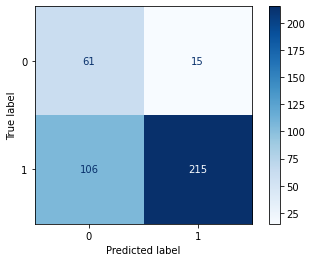

In [ ]:
X1, y1= getData(10, pick_channels=pick_channel)
X1 = X1.reshape(len(X1),-1)
X1 = X1.reshape(X1.shape[0], chans, samples, kernels)
# y1 = np_utils.to_categorical(y1)
probs = model.predict(X1)
print(classification_report(probs>0.5,np_utils.to_categorical(y1)))
ConfusionMatrixDisplay.from_predictions(y1,probs.argmax(axis=1),
                                        cmap='Blues')

In [ ]:
# with open('readme.txt', 'a') as f:
#     f.write(' '.join(pick_channel))
#     f.write('\n')
#     f.write(report(0.5))

#SVM

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn import svm

svc = svm.SVC()
# pca = decomposition.PCA()

# pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])


In [ ]:
X1, y1= getData(6, pick_channels=pick_channel)
X1 = X1.reshape(len(X1),-1)
# y1 = np_utils.to_categorical(y1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.2, random_state=123)

Reading /content/drive/MyDrive/ERN-Data/sub-006/eeg/sub-006_task-ERN_eeg.fdt
Reading 0 ... 669695  =      0.000 ...   653.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
X2, y2= getData(10, pick_channels=pick_channel)
X2 = X2.reshape(len(X2),-1)
# y2= np_utils.to_categorical(y2)

Reading /content/drive/MyDrive/ERN-Data/sub-010/eeg/sub-010_task-ERN_eeg.fdt
Reading 0 ... 770047  =      0.000 ...   751.999 secs...
Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']


In [ ]:
# kernels, chans, samples = 1, X1.shape[1], X1.shape[-1]

In [ ]:
svc.fit(X1_train,y1_train)

SVC()

In [ ]:
probs = svc.predict(X2)
# y_val = np.argmax(y_val, axis=1)

In [ ]:
print(classification_report(probs,y2))

              precision    recall  f1-score   support

           0       0.38      0.47      0.42        62
           1       0.90      0.86      0.88       335

    accuracy                           0.80       397
   macro avg       0.64      0.66      0.65       397
weighted avg       0.82      0.80      0.81       397



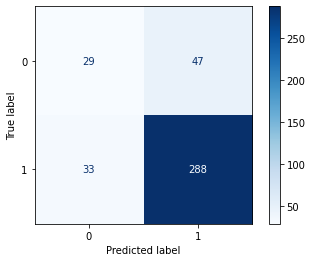

In [ ]:
ConfusionMatrixDisplay.from_predictions(y2,probs,
                                        cmap='Blues')
# plt.show()

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        33
           1       0.64      0.64      0.64        42

    accuracy                           0.60        75
   macro avg       0.59      0.59      0.59        75
weighted avg       0.60      0.60      0.60        75



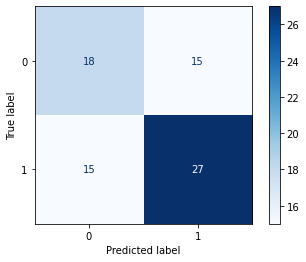

In [ ]:
probs = svc.predict(X1_test)
print(classification_report(probs,y1_test))
ConfusionMatrixDisplay.from_predictions(y1_test,probs,
                                        cmap='Blues')

#KNN

In [ ]:
from sklearn import neighbors

In [ ]:
knn=neighbors.KNeighborsClassifier(n_neighbors=5,)

In [ ]:
X_ = X_train.reshape(len(X_train),-1)

In [ ]:
knn.fit(X_train.reshape(len(X_train),-1),y_train.argmax(axis=1))

KNeighborsClassifier()

In [ ]:
y2_pred = knn.predict(X_test.reshape(len(X_test),-1))

In [ ]:
print(classification_report(y_test.argmax(axis=1), y2_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       452
           1       0.64      0.67      0.65       436

    accuracy                           0.65       888
   macro avg       0.65      0.65      0.65       888
weighted avg       0.65      0.65      0.65       888



In [ ]:
accuracy_score(y_test.argmax(axis=1), y2_pred)

0.6531531531531531

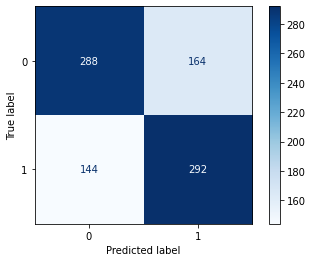

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1),y2_pred,
                                        cmap='Blues')

              precision    recall  f1-score   support

           0       0.94      0.60      0.73        52
           1       0.50      0.91      0.65        23

    accuracy                           0.69        75
   macro avg       0.72      0.75      0.69        75
weighted avg       0.80      0.69      0.70        75



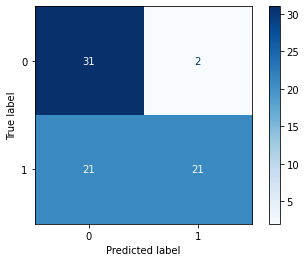

In [ ]:
probs = knn.predict(X1_test)
print(classification_report(probs,y1_test))
ConfusionMatrixDisplay.from_predictions(y1_test,probs,
                                        cmap='Blues')

Pyriemann

In [ ]:
svc = svm.SVC()

In [ ]:
# X_train.reshape(len(X_train),-1).shape

In [ ]:
svc.fit(X_train.reshape(len(X_train),-1),y_train.argmax(axis=1))

SVC()

In [ ]:
probs = svc.predict(X_test.reshape(len(X_test),-1))
# y_val = np.argmax(y_val, axis=1)

In [ ]:
print(classification_report(y_test.argmax(axis=1),probs,))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       452
           1       0.84      0.85      0.84       436

    accuracy                           0.85       888
   macro avg       0.85      0.85      0.85       888
weighted avg       0.85      0.85      0.85       888



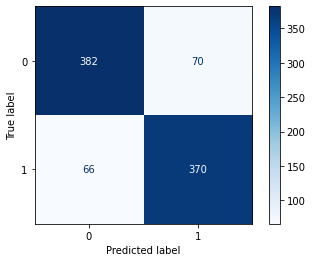

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1),probs,
                                        cmap='Blues')
# plt.show()

In [ ]:
knn.fit(X_train.reshape(len(X_train),-1),y_train.argmax(axis=1))

KNeighborsClassifier()

In [ ]:
y2_pred = knn.predict(X_test.reshape(len(X_test),-1))

In [ ]:
print(classification_report(y_test.argmax(axis=1), y2_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       452
           1       0.64      0.67      0.65       436

    accuracy                           0.65       888
   macro avg       0.65      0.65      0.65       888
weighted avg       0.65      0.65      0.65       888



In [ ]:
accuracy_score(y_test.argmax(axis=1), y2_pred)

0.6531531531531531

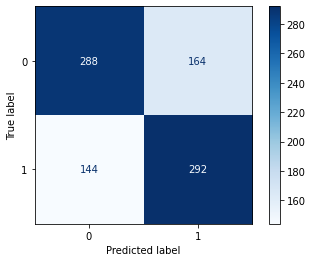

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1),y2_pred,
                                        cmap='Blues')

In [ ]:
# !pip install pyriemann

In [ ]:
# import pyriemann

In [ ]:
# knn = pyriemann.classification.KNearestNeighbor()

In [ ]:
# X1, y1= getData(6, pick_channels=pick_channel)
# X2, y2= getData(1, pick_channels=pick_channel)

In [ ]:
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.2, random_state=123)

In [ ]:
# knn = knn.fit(X1_train,y1_train)

In [ ]:
# probs = knn.predict(X1_test)
# print(classification_report(probs,y1_test))
# ConfusionMatrixDisplay.from_predictions(y1_test,probs,
#                                         cmap='Blues')

In [ ]:
# X1_train.shape

In [ ]:
# X1_test.shape

In [ ]:
a = np.arange(10).reshape(2,5)

In [ ]:
a

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [ ]:
a.reshape(5,2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [ ]:
a

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])